In [1]:
import numpy as np
import pandas as pd
from datetime import date
import os

# Custom Libraries -->
%load_ext autoreload
%autoreload 2
from src.portfolio import Portfolio
from src.simulation import MonteCarloSimulation
from src.tradier import Tradier

In [2]:
%load_ext dotenv
%dotenv
access_token = os.environ.get("access_token")

SYMBOL = "TSLA"
START_DATE = "2015-01-01"
END_DATE = "2023-12-30"

tradier = Tradier(access_token)

In [3]:
daily_std = tradier.getVolatility(SYMBOL, START_DATE, END_DATE)
print("Daily STD:", daily_std)

price = tradier.getMarketPrice(SYMBOL)
print("Price:", price)

Daily STD: 2.333191344184291
Price: 227.22


In [4]:
expiration_dates = tradier.getSymbolExpirationDates(SYMBOL)
print("Expiration Dates:", expiration_dates)

expiration = expiration_dates[8]
today = date.today()
NUM_OF_DAYS = np.busday_count(today, expiration)

Expiration Dates: ['2024-01-12', '2024-01-19', '2024-01-26', '2024-02-02', '2024-02-09', '2024-02-16', '2024-02-23', '2024-03-01', '2024-03-15', '2024-04-19', '2024-05-17', '2024-06-21', '2024-07-19', '2024-08-16', '2024-09-20', '2025-01-17', '2025-06-20', '2025-09-19', '2025-12-19', '2026-01-16', '2026-06-18']


In [5]:
json_response = tradier.getOptionChain(SYMBOL, expiration)

call_strikes = [entry['strike'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]
call_bids = [entry['ask'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]
call_asks = [entry['bid'] if entry['option_type'] == "call" else None for entry in json_response['options']['option']]

put_strikes = [entry['strike'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]
put_bids = [entry['bid'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]
put_asks = [entry['ask'] if entry['option_type'] == "put" else None for entry in json_response['options']['option']]

option_data = {
    'call_strikes': call_strikes,
    'call_bids': call_bids,
    'call_asks': call_asks,
    'put_strikes': put_strikes,
    'put_bids': put_bids,
    'put_asks': put_asks
}

Adjusted Standard Deviation: 15.824473610029465


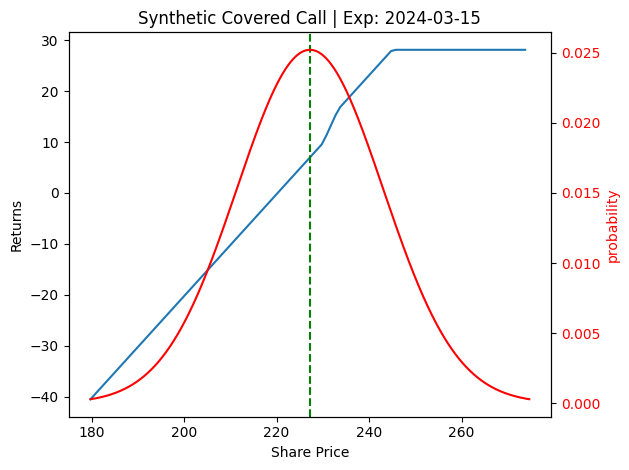

In [6]:
std = daily_std * np.sqrt(NUM_OF_DAYS)
print("Adjusted Standard Deviation:", std)

STD_WIDTH = 3
prices = np.arange(price - STD_WIDTH * std, price + STD_WIDTH * std, 1)

covered_call_strat = Portfolio(option_data, [
    # ATM Call PUT
    (price, expiration, 'Call', 'Long'),
    
    # ATM SHORT PUT
    (price, expiration, 'Put', 'Short'),
    
    # OTM SHORT CALL
    (price + std, expiration, 'Call', 'Short'),
])

covered_call_strat.draw(prices, price, std, expiration, showProbability=True, showMarkers=True)

In [7]:
import plotly.graph_objects as go

# Optimal Allocation Optimization
STARTING_BALANCE = 100_000
sample_size = 1000
NUM_TRIALS = 100

seed = np.random.randint(0, 1000)
np.random.seed(seed)

option_allocations = np.random.uniform(0, 1, sample_size)
cash_allocations = [1 - x for x in option_allocations]


In [8]:
Markowitz = pd.DataFrame(columns=['Index', 'Option Allocation',
                  'Cash Allocation', 'Returns', 'Volatility'])
MaxDrawdown = pd.DataFrame(columns=['Index', 'Option Allocation',
                  'Cash Allocation', 'Returns', 'Max Drawdown'])

for i, (option_allocation, cash_allocation) in enumerate(zip(option_allocations, cash_allocations)):
    cash_allocation = 1 - option_allocation

    simulation = MonteCarloSimulation(
        covered_call_strat, NUM_TRIALS, NUM_OF_DAYS, price, daily_std, STARTING_BALANCE)

    (result, volatility) = simulation.simulate(cash_allocation, option_allocation)

    temp = pd.DataFrame({
        'Index': i,
        'Option Allocation': option_allocation,
        'Cash Allocation': cash_allocation,
        'Returns': result,
        'Volatility': volatility,
    }, index=[0])

    Markowitz = pd.concat([Markowitz, temp])

    (result, maxDrawdown) = simulation.run(cash_allocation, option_allocation, display=False)

    temp = pd.DataFrame({
        'Index': i,
        'Option Allocation': option_allocation,
        'Cash Allocation': cash_allocation,
        'Returns': result,
        'Max Drawdown': maxDrawdown,
    }, index=[0])

    MaxDrawdown = pd.concat([MaxDrawdown, temp])

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    # x=df['Volatility'] / np.sqrt(NUM_OF_DAYS),
    x=Markowitz['Volatility'],
    y=Markowitz['Returns'],
    mode='markers',
    marker=dict(
        color=Markowitz['Option Allocation'],
        colorscale='RdBu',
        size=7,
        colorbar=dict(title="Option<br>Allocation")
    )
))
fig.update_layout(
    template="plotly_white",
    title="Monte Carlo Simulation of " + SYMBOL + " | Seed: " + str(seed) + " | Trails: " + str(NUM_TRIALS),
    xaxis_title="Risk Volatility (Standard Deviation)",
    yaxis_title="Expected Return",
)
fig.update_layout(coloraxis_colorbar=dict(title="Option Allocation"))

In [10]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=MaxDrawdown['Max Drawdown'],
    y=MaxDrawdown['Returns'],
    mode='markers',
    marker=dict(
        color=MaxDrawdown['Option Allocation'],
        colorscale='RdBu',
        size=7,
        colorbar=dict(title="Option<br>Allocation")
    )
))
fig.update_layout(
    template="plotly_white",
    title="Monte Carlo Simulation of " + SYMBOL +
    " | Seed: " + str(seed),
    xaxis_title="Max Drawdown",
    yaxis_title="Returns",
)
fig.update_layout(coloraxis_colorbar=dict(title="Option Allocation"))